# SQM Plot - Base

Este código foi feito com o intuito de gerar mapas de poluição luminosa a partir de dados fotométricos obtidos por meio de um Sky quality Meter (SQM). <br>
***Code by Raimundo Ferreira (Projeto Astroturismo nos Parques Brasileiros)***

### Importando bibliotecas -

In [1]:
import astropy #Biblioteca de funções astrofísicas
import matplotlib.pyplot as plt #Biblioteca de geração de gráficos
import matplotlib as mpl #Biblioteca de geração de gráficos
import numpy as np #Biblioteca de manipulação de listas e matrizes
import pandas as pd #Biblioteca de analise de banco de dados e leitura/escrita de arquivos externos
from astroquery.vizier import Vizier #Biblioteca para importar catálogos astronômicos
from astropy import units as u #Biblioteca utilitária para definir unidades de medidas
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun #Biblioteca de manipulação de cordenadas geográficas e astronômicas
from astropy.time import Time #Biblioteca de manipulação de medidas de tempo
from matplotlib.colors import LinearSegmentedColormap #Biblioteca para geração de barras de cores
from matplotlib.offsetbox import OffsetImage, AnnotationBbox #Biblioteca utilitária para geração de gráficos
from matplotlib.ticker import FormatStrFormatter #Biblioteca utilitária para geração de gráficos
from mpl_toolkits.mplot3d import Axes3D #Biblioteca utilitária para geração de gráficos com 3 eixos
from scipy.interpolate import griddata #Biblioteca de funções matemáticas para fazer a interpolação

### Definindo a Color Bar -

Geração de uma color bar personalizada, normalizada, para atender as necessidades do projeto. Nessa escala, o branco representa o céu mais "claro" ou seja, com maior presença da poluição luminosa.

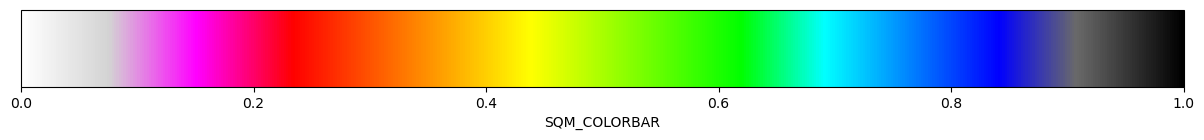

In [2]:
#Definindo as cores e a posição na color bar
cores = ['white', "lightgray", 'magenta', 'red' ,'yellow', 'lime', 'cyan', 'blue', "dimgrey" ,'black']
posicoes = [0, 0.075, 0.15, 0.2333333333333333, 0.4383333333333333, 0.62, 0.6916666666666667, 0.8416666666666667, 0.9083333333333334, 1]

#Gerando uma matriz 2x9, para atribuir uma cor para cada posição da lista. Type list
cores_cont = [(posicoes[i], cor) for i, cor in enumerate(cores)]

#Transformação da matriz na color bar.
cmap = LinearSegmentedColormap.from_list('MeuColormap', cores_cont, N=500) #N indica a quantidade de cores dentro da color bar entre as primárias de input

#Visualização da color bar
fig, ax = plt.subplots(figsize=(15, 1))
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=ax, orientation='horizontal')
cbar.set_label('SQM_COLORBAR')
plt.show()

### Busca pelas cordenadas estelares

A parte mais técnica do código. Utilizamos de um função definida como estelar_az_al() para retornar os valores de Azimute e Altitude das estrelas com magnitude inferir a 6 mag visível durante o momento de geração do mapa. <br>
A entrada da função será 3 variáveis, 2 floats que indicarão os valores de latitude e longitude de onde os dados foram obtidos, e uma string no formato ("YYY-MM-DDThh:mm:s"), indicando o dia e o horário em que os valores foram coletados. <br>
O catálogo de onde os dados são obtidos é o The Hipparcos Main Catalogue.

In [3]:
def estelar_az_al(latitude, longitude, dados_tempo):
    ''' 
    Está função recebe os dados geográficos e temporais e retorna as cordenadas das estrelas visíveis no céu com magnitude inferior a 6mag.

    Parameters:
        latitude (float): Latitude de onde os dados foram obtidos, em números inteiros. Valores positivos para Leste e Negativos para Oeste.
        longitude (float): Longitude de onde os dados foram obtidos, em números inteiros. Valores positivos para Norte e Negativos para Sul.
        dados_tempo (string): Na forma de 2000-00-00T00:00:00 (ano-mes-dataThora:min:seg), representa os valores temporais de quando os dados foram coletados
        
    Return:
        vmag (array[float]): Magnitude da banda V dos objetos
        azimuth (array[float]):
        altitude (array[float]): 
    '''
    data_location = EarthLocation(lat=float(latitude)*u.deg, lon=float(longitude)*u.deg) #Transformando os valores de latitude e longitude no objeto EarthLocation
    obs_time = dados_tempo #Transformando os valores temporais no objeto Time

    #Acessando o catalogo Hipparcos
    vizier = Vizier(catalog='I/239')
    vizier.ROW_LIMIT = 100000000000 #Limite de objetos buscados

    #Definindo a região que será buscada no céu e impondo o limite de magnitude
    result = vizier.query_region(SkyCoord(ra=0, dec=0, unit=(u.deg, u.deg), frame='icrs'), radius=180*u.deg, column_filters={"Vmag": "<6"}) 
    table = result['I/239/hip_main'] #Geração da tabela com todos os dados coletados no Hipparcos

    #Gerando uma array (lista) apenas com os valores de RA e DEC
    ra = np.array(table["RAICRS"])
    dec = np.array(table["DEICRS"])

    #Transformando os valores de RA e DEC em AZ e ALT
    altaz_frame = AltAz(obstime=obs_time, location=data_location)
    coords_altaz = SkyCoord(ra, dec, unit=(u.deg, u.deg)).transform_to(altaz_frame)

    #Definindo os valores a serem retornados
    vmag = np.array(table["Vmag"]) 
    azimuth = np.array(coords_altaz.az.deg)
    altitude = np.array(coords_altaz.alt)

    return vmag, azimuth, altitude

### Geração dos mapas

A coleta de dados é feito pela medição de 50 pontos do céu. Como a ideia aqui é geração de um mapa, esses pontos coletados são interpolados na grade em projeção polar. <br>
O input inicial é feito com a entrada do arquivo .csv com os pontos medidos com o fotômetros. <br>
O código ainda está em otimização, e é necessário que os valores que ocupam a posição do 0º seja também repetido para 360º para complementar a interpolação, isso ainda deve ser feito manualmente.

In [4]:
estelar_az_al(-20.250, -46.4149, "2024-07-10T04:55:00") #PESET - lat=-23, lon=-43, obstime=2023-09-08T20:45:00
                                                        #Curral de pedras -20.2185, -46.4968, "2024-07-11T04:55:00"
                                                        #Trilha -20.2500, -46.4149, "2024-07-10T04:55:00"

(array([5.71, 5.53, 4.78, ..., 5.59, 5.81, 4.49], dtype=float32),
 array([139.42407001, 141.35950976, 169.48139707, ..., 111.83276838,
         38.48883243, 158.82922024]),
 array([44.48856844, 43.84998344, 29.19726183, ..., 49.07450666,
        21.42860762, 36.41802331]))

In [ ]:
#Input do diretório do arquivo .csv com os dados medidos
    # /home/raimundo/Documentos/UFRJ/Extensão/Astroturismo/ov.csv
    # /home/raimundo/Documentos/UFRJ/Extensão/Astroturismo/sqm.csv
    # /home/raimundo/Documentos/UFRJ/Extensão/Astroturismo/teste.csv
dir = str(input("Informe o diretório do arquivo .csv: "))

#Leitura do arquivo de entrada
df = pd.read_csv(dir, sep=",")

#Acessando os valores do arquivo
theta = np.radians(df['AZIMUTE'])
r = df['ALTURA']
values = df['SQM-L']

#### Definindo as configurações de layout na color bar -

In [ ]:
cbar_min = 16 #Limite inferior de magnitude
cbar_max = 22 #Limite superior de magnitude

cbar_levels = np.linspace(cbar_min, cbar_max, 1000) #Determinando a quantidade de valores entre o mínimo e o máximo

#### Definindo a grade de valores do plot polar - 

A interpolação linear ajusta uma curva linear, gerando um plot menos suave. Já a interpolação cública ajusta uma função de 3 grau, de forma a suavizar o plot.

In [ ]:
#Criando a lista de valores para os angulos e raio do plot polar, quando maior o valor, mais suave o plot
theta_interp = np.linspace(0, 2 * np.pi, 2000)
r_interp = np.linspace(r.min(), r.max(), 2000)

theta_grid, r_grid = np.meshgrid(theta_interp, r_interp) #Geração da grade com as listas geradas

#Atribuindo o valor nos pontos da grade através da interpolação dos pontos coletados
values_grid = griddata((theta, r), values, (theta_grid, r_grid), method='cubic', fill_value=0) #Método de interpolação

#### Plot - 

In [ ]:
#Parâmetros da figura
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize = (14,10)) #figsize, define o tamanho da imagem como um todo
plt.title('Pico do Grama - PESB', fontsize = 18, y=1.08) #Título do plot

ax.set_xlim(np.radians(-45),np.radians(135))
ax.set_theta_offset(np.radians(90)) #Coloca o Norte na parte superior
ax.set_theta_direction(-1) #Inverte o sentido do azimmute
ax.set_ylim(90,40) #Limita os valores de altura entre 90 - 20º,invertendo a situação original (0 - 90) e limitando


#Gerando os gráficos 
contour = ax.contourf(theta_grid, r_grid, values_grid, levels=cbar_levels, extend='both', cmap=cmap) #Contornos preenchidos
#contour_plot = ax.contour(theta_grid, r_grid, values_grid, levels=5, colors='white', linewidths=1.5, alpha= 0.6) #Linhas de nível

#Inserindo a colorbar personalizada
cbar = plt.colorbar(contour, label='Escala de magnitude')
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.text(1.09, 1.05, 'SQM', transform=ax.transAxes, fontsize=16, ha="center") #Título da colorbar
plt.text(1.09, 1.02, '(mag/arcsec²)', transform=ax.transAxes, fontsize=10, ha="center") #Grandeeza da medida

#Inserir textos
plt.text(0.12, -0.07, 'Data - 08/08/2024', transform=ax.transAxes, fontsize=13)
plt.text(0.12, -0.11, 'Hora - 23:30h', transform=ax.transAxes, fontsize=13)

plt.text(0.78, -0.07, 'Zênite - $21.59 \pm 0.00$', transform=ax.transAxes, fontsize=13)
plt.text(0.78, -0.11, 'Temperatura = $10.0°$', transform=ax.transAxes, fontsize=13)

#Plotar mapa estelar
vmag, azimuth, altitude = estelar_az_al(-20.7259, -42.4790, "2024-08-08T23:30:00") #PESET - lat=-23, lon=-43, obstime=2023-09-08T20:45:00
                                                                            #OV - lat=-22.89, lon=-43.18, obstime=2023-03-22T20:45:00
plt.scatter(np.radians(azimuth), altitude, marker='o', label='Objetos', color="white", s=(83 - 110 * np.log10(vmag))*0.7, alpha = 0.8)

#Configurações finais do plot
plt.savefig('capela.png', dpi=500, bbox_inches='tight') #Salva o plot em uma imagem .png
plt.show()